# **Projet 5 - <span style="color:#0B28D0">Segmentez les clients d'un site e-commerce</span>**
---

**<span style="color:#0B28D0">Objectif de la mission:</span>**
* Fournir une **segmentation des clients** afin d'apporter des informations supplémentaires aux équipes pour leurs campagnes de communication.
* **Comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.
* Fournir une **description actionable de la segmentation** et de sa logique sous-jacente pour une utilisation optimale.
* Proposition de **contrat de maintenance basée sur une analyse de la stabilité** des segments au cours du temps..

## **0. Importation des librairies et des données**
---

In [187]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import plotly.graph_objects as go
# ---
#scikit-learn
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
#classe pour l'ACP
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
#Classes pour le clustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

In [2]:
path_customers = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P5_Segmentez_Des_Clients_Dun_Site_e_commerce/df_final.csv"
df_customers = pd.read_csv(path_customers, sep=",")
df = df_customers.copy()

### **0.1 - Définition de la charte graphique**

In [3]:
["#0B28D0","#A2A2D5","#FFF","#333","#EDAD01"]

['#0B28D0', '#A2A2D5', '#FFF', '#333', '#EDAD01']

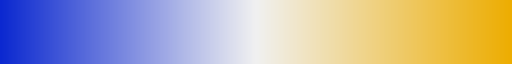

In [4]:
# Define the heatmap color
first_color = "#0B28D0"
under_color = "#F1F1F1"
over_color = "#EDAD01"
# Create a personal color map 
colors = [first_color,under_color, over_color]
n_bins = 400
cmap_name = 'custom_colormap'
heatmap_color = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
heatmap_color

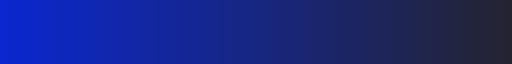

In [5]:
palette_b = sns.dark_palette("#0B28D0", reverse=True, as_cmap=True)
palette_b

In [6]:
# Colour palette for the various graphics
n_colors = 10
palette_map = sns.color_palette("dark:#0B28D0", n_colors=n_colors,as_cmap=False)
palette_map

[(0.14217064351973224, 0.14390410693260464, 0.19354284782618525),
 (0.13129638908327107, 0.14532701622135824, 0.26185663585419044),
 (0.12042213464680988, 0.14674992551011184, 0.33017042388219564),
 (0.10915951398047509, 0.1482236529877495, 0.4009239900540581),
 (0.0982852595440139, 0.1496465622765031, 0.4692377780820633),
 (0.08702263887767911, 0.15112028975414074, 0.5399913442539259),
 (0.07614838444121794, 0.15254319904289435, 0.6083051322819311),
 (0.06488576377488314, 0.154016926520532, 0.6790586984537935),
 (0.05401150933842197, 0.1554398358092856, 0.7473724864817987),
 (0.043137254901960784, 0.1568627450980392, 0.8156862745098039)]

### **0.2 - Normalisation de l'affichage des graphiques**

In [7]:
# Defines display options for rows and columns
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

In [8]:
# Defines title formatting
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = '#000'
plt.rcParams['axes.titlepad'] = 20
# Defines axis formatting
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelcolor'] = '#EDAD01'
#Defines scale formatting
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['xtick.color'] = '#333'
plt.rcParams['ytick.color'] = '#333'

In [9]:
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2,
              rc={"axes.titlesize":16, 
                  "axes.labelsize":10, 
                  "xtick.labelsize":8, 
                  "ytick.labelsize":8, 
                  "xtick.color":"#333", 
                  "ytick.color":"#333", 
                  "axes.titlecolor":"#000", 
                  "axes.labelcolor":"#EDAD01"
                  })

## **1. Traitement des données**
***

In [10]:
df.sample(1)

,customer_unique_id,review_score,payment_installments,payment_sequential,average_price,average_freight_value,average_product_weight_g,product_volume_cm3,nb_product_per_order,days_since_last_order,nb_orders_per_customer
4717,0ca34b61e26e5432f38297c3d7bd57a5,4.0,3.0,1.0,29.9,9.34,450.0,2400.0,1.0,192.0,1.0


La colonne `customer_unique_id` est supprimée pour le clustering.

In [11]:
df = df.drop(columns="customer_unique_id")

Les données sont normalisées à 2 chiffres après la virgule.

In [12]:
df = df.round(2)

Et les types des données est vérifié avant le clustering.

In [13]:
df.dtypes

review_score                float64
payment_installments        float64
payment_sequential          float64
average_price               float64
average_freight_value       float64
average_product_weight_g    float64
product_volume_cm3          float64
nb_product_per_order        float64
days_since_last_order       float64
nb_orders_per_customer      float64
dtype: object

## **2. Clustering**
***

Le clustering est testé dans un premier temps à partir des données minimales d'une segmentation RFM (Récence,Fréquence,Montant) + `review_score`.

Cette segmentation n'ayant pas permit une dichotomie des clients suffisamment pertinente, la variable `payment_installments` a été ajouté aux données.

In [14]:
df_cluster = df[["review_score","payment_installments","average_price","days_since_last_order","nb_orders_per_customer"]]

Il est interessant d'observer les associations entre les variables avant le clustering puisque qu'une forte corrélation signifie potentiellement que l'ont apporte une information similaire, ce qui peut être contre-productif pour la segmentation.

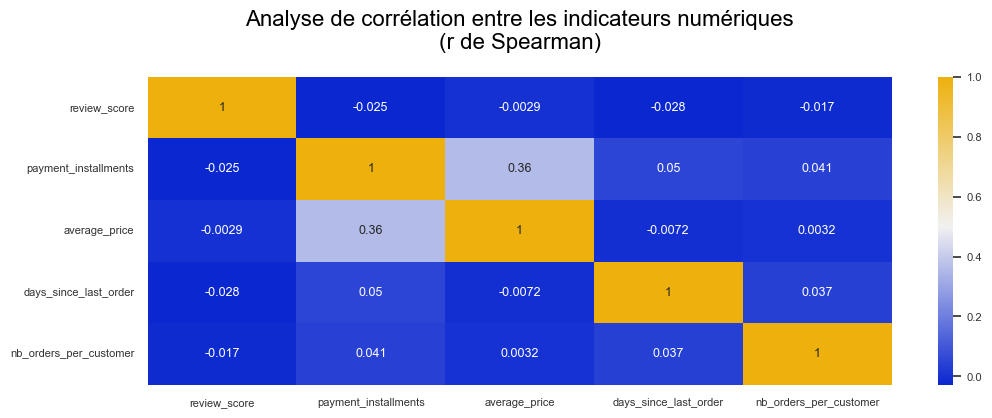

In [15]:
# Analysis of correlations between variables
plt.figure(figsize=(12,4))
sns.heatmap(df_cluster.corr(method="spearman"), center=0.5, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('Analyse de corrélation entre les indicateurs numériques\n(r de Spearman)')
plt.show()

Globalement, les données ne présentent pas d'association à l'exception des variables `average_price` et `payment_installments` (peu significatif).

Les données sont centrées et réduites (moyenne=0; Ecart-type=1) afin d'être utilisées pour les différentes méthodes de clustering.

In [16]:
sc = StandardScaler()
X = sc.fit_transform(df_cluster)

### **2.1   K-Means**

La méthode des KMeans est testé dans un premier temps. 

Cette méthode consiste a sélectionner aléatoirement k points de données (k=nb de cluster) comme centroïdes et d'attribuer chaque point de données à l'un d'eux. Cela se fait en calculant la distance entre le point de données et chaque centroïde. Puis les positions des centroïdes K sont recalculés. Le nouveau centroïde d'un cluster est calculé en prenant la moyenne de tous les points de données dans le cluster.

#### **2.1-1   Mesure de Qualité**

Les indices de Davies-Bouldin et de Silhouette sont utilisés pour mesurer la qualité des clusters. Ils permettent d'obtenir un indice de qualité qui détermine le nombre de cluster optimal d'un point de vue statistique. Cependant, le choix du nombre de cluster dépend aussi du contexte et des objectifs de l'analyse, qui est ici la segmentation des clients dans le but d'identifier leurs comportements. 

##### **Indice de Davies-Bouldin**

Cet indice compare la moyenne des distances intra-cluster avec les distances entre les centroïdes des clusters (mesurant la séparation des clusters). Un indice de Davies-Bouldin plus faible indique un meilleur clustering, car il signifie que les clusters sont plus compacts et mieux séparés.

L'indice de Davin-Bouldin est calculé pour un clusetering allant de 2 à 10 clusters. 

In [17]:
score_bouldin = []

for n_clust in range(2,10):
    # K-means clustering with K-means++ initialization
    km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
    km.fit(X)
    # Retrieve the clusters assigned to each individual
    clusters = km.labels_
    # Application of the Davies Bouldin measurement
    score_bouldin.append(davies_bouldin_score(X, km.labels_))

print(score_bouldin)

[1.6110071982533045, 1.23163869541353, 1.1919636711000252, 1.0043660630951332, 0.8973376301983434, 1.0183787500665182, 1.1268192955028655, 1.1836261512153825]


Les résultats montrent qu'un nombre de 6 clusters serait optimal pour la segmentation des clients.

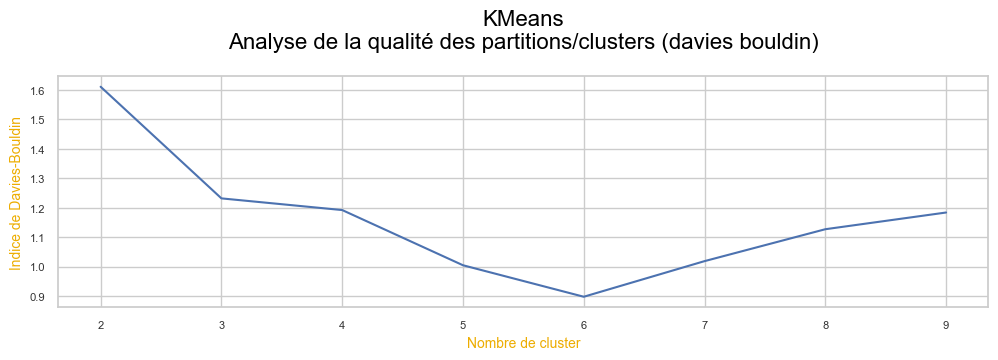

In [18]:
# Cluster analysis
plt.figure(figsize=(12,3))
plt.plot(range(2,10), score_bouldin)
plt.title('KMeans\nAnalyse de la qualité des partitions/clusters (davies bouldin)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

##### **Indice de Silhouette**

Pour chaque point de données, l'indice de Silhouette est la différence entre la distance moyenne avec les points du même cluster (cohésion) et la distance moyenne avec les points des autres clusters (séparation), divisée par la plus grande des deux distances. Une valeur proche de 1 indique que le point de données est bien assigné à son cluster, tandis qu'une valeur proche de -1 indique qu'il serait mieux assigné à un autre cluster.

L'indice de Silhouette est calculé pour un clusetering allant de 2 à 10 clusters également. 

In [19]:
score_silhouette = []

for n_clust in range(2,10):
 # Clustering par K-means avec initialisation K-means++
 km = KMeans(n_clusters=n_clust, init='k-means++', n_init='auto', random_state=42, verbose=1)
 km.fit(X)
 # Récupération des clusters attribués à chaque individu
 clusters = km.labels_
 # Application de la mesure Silhouette
 score_silhouette.append(silhouette_score(X, km.labels_))
 print("silhouette terminé")

print(score_silhouette)

Initialization complete
Iteration 0, inertia 602066.8966087155.
Iteration 1, inertia 396702.98149935796.
Iteration 2, inertia 392837.04463496374.
Iteration 3, inertia 391488.96333275427.
Iteration 4, inertia 391138.5231546576.
Iteration 5, inertia 391032.51756295667.
Iteration 6, inertia 391007.4912143452.
Iteration 7, inertia 391002.52639080724.
Converged at iteration 7: center shift 3.070047689368268e-05 within tolerance 9.999999999999876e-05.
silhouette terminé
Initialization complete
Iteration 0, inertia 523101.0346676531.
Iteration 1, inertia 320402.86674736993.
Iteration 2, inertia 316654.542842144.
Iteration 3, inertia 315354.39581060666.
Iteration 4, inertia 315009.2365134312.
Iteration 5, inertia 314904.55487638095.
Iteration 6, inertia 314879.7666162833.
Iteration 7, inertia 314875.9620520891.
Converged at iteration 7: center shift 2.603475422277991e-05 within tolerance 9.999999999999876e-05.
silhouette terminé
Initialization complete
Iteration 0, inertia 385532.24404030107.


Les résultats montrent qu'un nombre de 7 ou 4 clusters serait optimal pour la segmentation des clients.

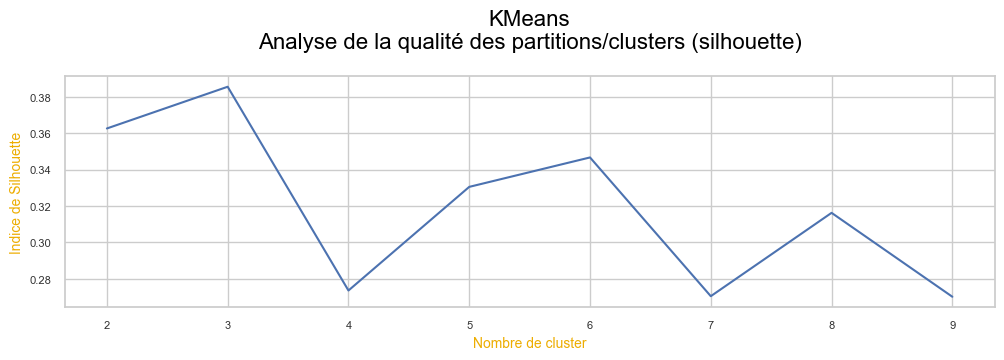

In [20]:
#Analyse des regroupements de clusters
plt.figure(figsize=(12,3))
plt.plot(range(2,10), score_silhouette)
plt.title('KMeans\nAnalyse de la qualité des partitions/clusters (silhouette)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Silhouette")
plt.show()

#### **2.1-2   Clustering**

Après plusieurs essais, il s'avère qu'une segmentation en 5 clusters soit la plus adaptée aux données. Le modèle KMeans est donc instancié avec ces paramètres puis appliqué aux données. 

In [21]:
n_clust = 5
km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
km.fit(X)

KMeans(n_clusters=5, n_init='auto', random_state=42)

Les résultats de labelisation de chacun des points de données est ensuite enregistré dans la variable `clusters`.

In [22]:
clusters = km.labels_

La matrice des résultats du clustering est transformée en dataframe et les résultats de labelisation sont ajoutés à la colonne `clusters`.

In [23]:
df_kmean = pd.DataFrame(X, columns=df_cluster.columns)
df_kmean['clusters'] = clusters

#### **2.1-3   Analyse des clusters**

##### **Analyse des centroïdes**

Les centroïdes de chaque clusters sont obtenus en calculant la moyenne de chaque caractéristiques, le but étant d'analyser le comportements global des clients pour chacun des clusters.

In [182]:
centroide_kmean = df_kmean.groupby(by='clusters').mean()

In [183]:
centroide_kmean.reset_index(inplace=True)

Observation des valeurs moyennes par cluster pour chacun des indicateurs.

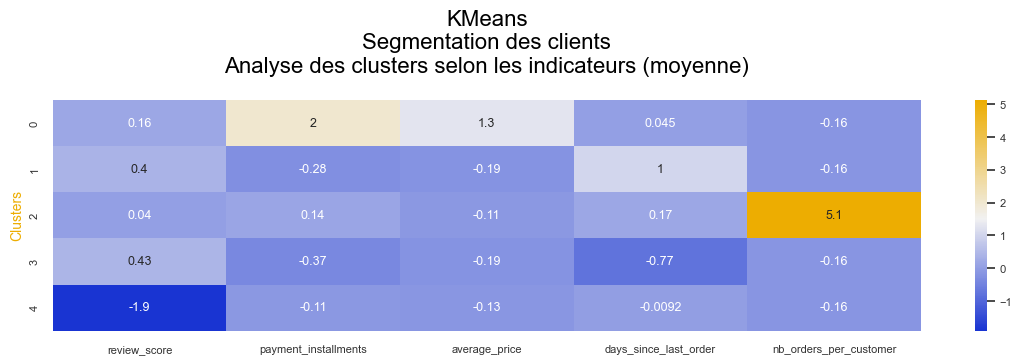

In [184]:
plt.figure(figsize=(14,3))
sns.heatmap(centroide_kmean.set_index("clusters"), center=1.5, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('KMeans\nSegmentation des clients\nAnalyse des clusters selon les indicateurs (moyenne)')
plt.ylabel('Clusters')
plt.show()

L'analyse des centroïdes permet de se faire une première interprétation des caractéristiques communes aux clients pour chacun des clusters:

* **0** -> Regroupe les clients qui dépensent le plus et qui paient en plusieurs fois;
* **1** -> Correspond aux clients les plus anciens; (plus le chiffre est bas, plus le client est récent)
* **2** -> Contient les clients ayant effectués plusieurs commandes;
* **3** -> Correspond aux clients les plus récents; (plus le chiffre est bas, plus le client est récent)
* **4** -> Regroupe les clients mécontents.

Les clusters sont ainsi renommés pour la suite des analyses.

In [185]:
centroide_kmean["clusters"].replace({0:"Clients dépensiers",
                                     1:"Clients de longue date",
                                     2:"Clients récurrents",
                                     3:"Clients récents",
                                     4:"Clients mécontent"}, inplace=True)

Observation des résultats afin d'expliquer le clustering au travers une représentation de type radarplot.

In [190]:
categories = centroide_kmean.drop(columns="clusters").columns.tolist()
max_value = centroide_kmean.select_dtypes(float).values.max()
colors = ["#0B28D0","#A2A2D5","#FFF","#333","#EDAD01"]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=centroide_kmean.iloc[0,1:].tolist(),
      theta=categories,
      fill='toself',
      hovertemplate='Moy_Cluster: %{r}',
      name=centroide_kmean["clusters"][0],
      marker=dict(color=colors[0])
))
fig.add_trace(go.Scatterpolar(
      r=centroide_kmean.iloc[1,1:].tolist(),
      theta=categories,
      fill='toself',
      hovertemplate='Moy_Cluster: %{r}',
      name=centroide_kmean["clusters"][1],
      marker=dict(color=colors[1])
))
fig.add_trace(go.Scatterpolar(
      r=centroide_kmean.iloc[2,1:].tolist(),
      theta=categories,
      fill='toself',
      hovertemplate='Moy_Cluster: %{r}',
      name=centroide_kmean["clusters"][2],
      marker=dict(color=colors[2])
))
fig.add_trace(go.Scatterpolar(
      r=centroide_kmean.iloc[3,1:].tolist(),
      theta=categories,
      fill='toself',
      hovertemplate='Moy_Cluster: %{r}',
      name=centroide_kmean["clusters"][3],
      marker=dict(color=colors[3])
))
fig.add_trace(go.Scatterpolar(
      r=centroide_kmean.iloc[4,1:].tolist(),
      theta=categories,
      fill='toself',
      hovertemplate='Moy_Cluster: %{r}',
      name=centroide_kmean["clusters"][4],
      marker=dict(color=colors[4])
))

fig.update_layout(
    polar=dict(radialaxis=dict(range=[-0.5, 2.1],visible=True),angularaxis=dict(tickfont=dict(size=14, color='#333')), bgcolor='rgba(11, 40, 208, 0.3)'),
    showlegend=True,
    title=dict(text="Moyenne des caractéristiques par cluster",x=0.5,y=0.95),
    title_font=dict(size=22, color='#000'),
    width=900,  # Width of the figure in pixels
    height=700,  # Height of the figure in pixels
)

fig.show()

##### **Analyse de distribution par cluster**

La distribution des individus par cluster est également observée pour chaque caractéristique.

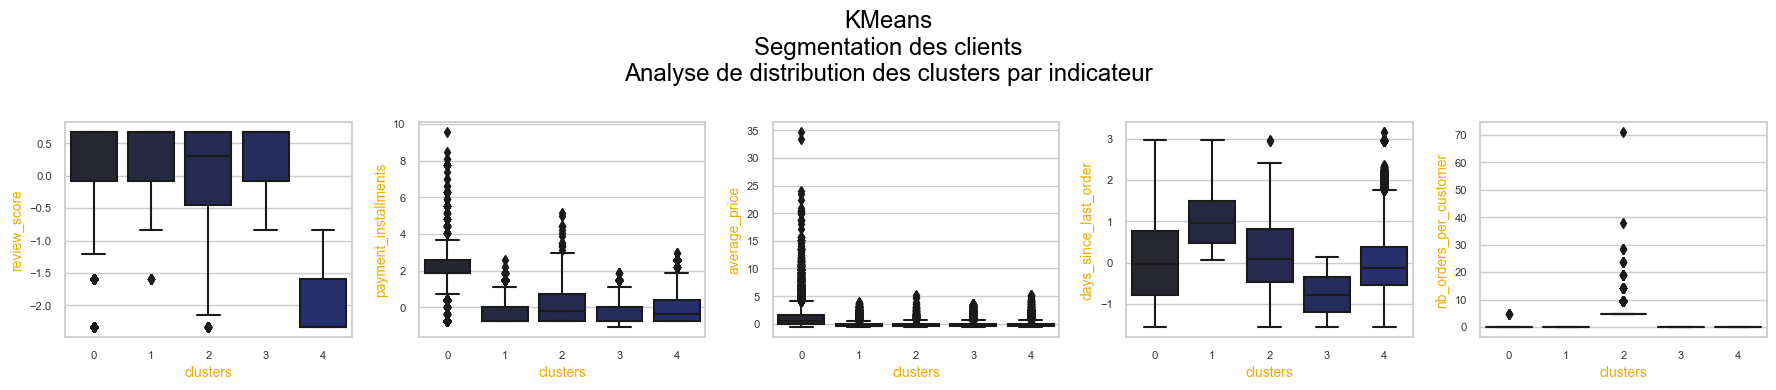

In [191]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
plt.suptitle("KMeans\nSegmentation des clients\nAnalyse de distribution des clusters par indicateur", color="#000")

for ax, column in zip(axs.flatten(), df_kmean.drop(columns="clusters").columns):
    sns.boxplot(x='clusters', y=column, data=df_kmean, ax=ax, palette=palette_map)

plt.tight_layout()
plt.show()

L'analyse des distributions montre une bonne segmentation des clients et confirme la première interprétation. Ainsi, chaque cluster peut être définit comme suit:

* **0** -> Clients les plus dépensiers et qui paient en plusieurs fois;
* **1** -> Client les plus anciens; (plus le chiffre est bas, plus le client est récent)
* **2** -> Clients ayant effectués plusieurs commandes;
* **3** -> Client les plus récents; (plus le chiffre est bas, plus le client est récent)
* **4** -> Client mécontents.

##### **Analyse de la répartition des individus par cluster**

In [193]:
nb_indiv_cluster = df_kmean["clusters"].value_counts().reset_index()

Les cluster sont renommés afin de les identifiés.

In [194]:
nb_indiv_cluster["clusters"].replace({0:"Clients dépensiers",
                                      1:"Clients de longue date",
                                      2:"Clients récurrents",
                                      3:"Clients récents",
                                      4:"Clients mécontent"}, inplace=True)

Puis le nombre d'individus est représenté via un radarplot.

In [195]:
# Convertissez les valeurs de 'clusters' en chaînes de caractères
nb_indiv_cluster["clusters"] = nb_indiv_cluster["clusters"].astype(str)

fig = go.Figure(data=go.Scatterpolar(
    r=nb_indiv_cluster["count"],
    theta=nb_indiv_cluster["clusters"],
    fill='toself',
    marker=dict(color='#0B28D0'),
    line=dict(color='#EDAD01'),
    fillcolor='rgba(237, 173, 1, 0.6)',
    hovertemplate='Nombre d\'individus: %{r}'
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True),angularaxis=dict(tickfont=dict(size=14, color='#333')), bgcolor='rgba(11, 40, 208, 0.3)'),
    showlegend=False,
    title=dict(text="Répartition des individus par cluster",x=0.5,y=0.95),
    title_font=dict(size=22, color='#000'),
    width=700,  # Width of the figure in pixels
    height=600,  # Height of the figure in pixels
)

fig.show()

##### **Représentation des individus par clusters**

###### **Normalisation des données**

In [ ]:
print(df.shape)
# Number of observations (tuples/country)
n = df.shape[0]
# Number of variables (columns)
p = df.shape[1]

In [ ]:
# Instanciation
sc = StandardScaler()
# Transformation - Scaling 
X = sc.fit_transform(df)
# Instanciation
acp = PCA(svd_solver='full')
#Calculs des composantes principales + renvoie en sortie les coordonnées factorielles
coord = acp.fit_transform(X)
#Nombre de composantes calculées
print(acp.n_components_)

###### **Calcul des valeurs propres**

In [ ]:
eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
# Correlation of variables with axes
corvar = np.zeros((p,p))
for k in range(p):
 corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

###### **Eboulis des valeurs**

In [ ]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree, color='#0b28d0')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="#edad01",marker='o')
    plt.title("Eboulis des valeurs propres\n")
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("% d'inertie")
    plt.show(block=False)

In [ ]:
#Eboulis des valeurs propres
plt.figure(figsize=(14,4))
display_scree_plot(acp)

###### **Représentation des individus**

In [ ]:
# Vos couleurs pré-déterminées
colors = ["#0B28D0", "#A2A2D5", "#000", "#333", "#EDAD01"]
# Création d'une ListedColormap avec vos couleurs
cmap = mpl.colors.ListedColormap(colors)
# Assurez-vous que les limites correspondent au nombre de clusters plus 1
bounds = [0, 1, 2, 3, 4, 5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# Créez un ScalarMappable avec la colormap et le normalisateur
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

# Supposons que 'df_kmean.clusters' contienne les identifiants de cluster pour chaque point
# Créez une liste de couleurs pour les clusters en utilisant une compréhension de liste
cluster_colors = [colors[cluster_id] for cluster_id in df_kmean.clusters]

# 1er plan factoriel
axs[0, 0].scatter(x=coord[:, 0], y=coord[:, 1], c=cluster_colors, s=6)
axs[0, 0].set_title("1er plan factoriel")
fig.colorbar(sm, ax=axs[0, 0])

# 2e plan factoriel
axs[0, 1].scatter(x=coord[:, 2], y=coord[:, 3], c=cluster_colors, s=6)
axs[0, 1].set_title("2e plan factoriel")
fig.colorbar(sm, ax=axs[0, 1])

# 3e plan factoriel
axs[1, 0].scatter(x=coord[:, 4], y=coord[:, 5], c=cluster_colors, s=6)
axs[1, 0].set_title("3e plan factoriel")
fig.colorbar(sm, ax=axs[1, 0])

# 4e plan factoriel
axs[1, 1].scatter(x=coord[:, 6], y=coord[:, 7], c=cluster_colors, s=6)
axs[1, 1].set_title("4e plan factoriel")
fig.colorbar(sm, ax=axs[1, 1])

plt.tight_layout()
plt.show()

#### **2.2   CAH - Classification Ascendante Hiérarchique**

La méthode de Classification Ascendante Hiérarchique est maintenant testée. 

Cette méthode consiste à organiser une population en groupes homogènes. Pour cela la CAH calcule une `matrice des distances` ou des dissimilarités entre les individus. Les individus sont ensuite agglomérés de manière itérative en suivant une procédure hiérarchique. À chaque étape, les deux groupes les plus proches (selon la matrice des distances) sont fusionnés pour former un nouveau groupe. Ce processus est répété jusqu'à ce que tous les individus soient regroupés en un seul cluster. Le résultat est représenté par un arbre appelé `dendrogramme`, qui illustre la manière dont les groupes sont combinés.

La méthode CAH ne fonctionne pas sur un échantillon d'individus important, par conséquent il est nécessaire de passer par un premier traitement afin de réduire la taille de l'échantillon. 

Ce traitement consiste a utiliser la méthode de clustering KMeans de manière à exploiter les centroïdes d'un grand nombre de clusters (`n_clust = 10000`). Cela permet de diviser par 9 (environ) le nombre d'individus tout en gardant l'information, en effet, cette méthode permet d'obtenir la moyenne des 9 individus les plus proches. 

Pour commencer, les données sont mises à l'échelles. Le modèle KMeans est ensuite appliqué aux données avec les paramètres prédéfinis.

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(df_cluster)

n_clust = 10000
km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
km.fit(X)

Les résultats de labelisation de chacun des points de données est ensuite enregistré dans la variable `clusters`.

In [ ]:
clusters = km.labels_

La matrice des résultats du clustering est transformée en dataframe et les résultats de labelisation sont ajoutés à la colonne `clusters`.

In [ ]:
df_kmean = pd.DataFrame(X, columns=df_cluster.columns)
df_kmean['clusters'] = clusters

Les centroïdes de chaque clusters sont obtenus en calculant la moyenne de chaque caractéristiques, réduisant ainsi le nombres d'individus dans l'échantillon.

In [ ]:
centroide_kmean = df_kmean.groupby(by='clusters').mean()
centroide_kmean.shape

Les données sont centrées et réduites avant l'application du clustering CAH et les individus sont instanciés dans la variables `names`.

In [ ]:
X = sc.fit_transform(centroide_kmean)

In [ ]:
names = centroide_kmean.index.values

La Classification Ascendante Hiérarchique est peut maintenant être appliquée aux données.

In [ ]:
# Clustering hiérarchique
Z = linkage(X, 'ward')

Avant de visualiser le dendogramme il est utilse de mesurer la qualité du clustering via l'indice de Davies-Bouldin.

In [ ]:
score = []

for n_clust in range(2,10):
  #Clustering par classification hiérarchique
  clusters = fcluster(Z, n_clust, criterion='maxclust')
  #Application de la mesure Davies Bouldin
  score.append(davies_bouldin_score(X, clusters))

print(score)

Le résultat montre qu'une segmentation en 6 clusters serait la plus adaptée. 

In [ ]:
#Analyse des regroupements de clusters
plt.figure(figsize=(14,3))
plt.plot(range(2,10), score)
plt.title('CAH\nAnalyse de la qualité des partitions/clusters (davies-bouldin)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

Les clusters sont représentés dans le dendogramme en se basant sur les résultats du Davies-Bouldin.

In [ ]:
plt.figure(figsize=(22,6))
dendrogram(Z,labels=names,orientation='top',color_threshold=59, above_threshold_color='#bcbddc')
plt.title('CAH\nDendogramme représentant les 6 classes')
plt.xlabel('Distance')
plt.ylabel('Classes')
plt.show()

Les résultats de labelisation de chacun des points de données est ensuite enregistré dans la variable `clusters`.

In [ ]:
clusters = fcluster(Z, 6, criterion='maxclust')

La matrice des résultats du clustering est transformée en dataframe et les résultats de labelisation sont ajoutés à la colonne `clusters`.

In [ ]:
df_cah = pd.DataFrame(X, columns=centroide_kmean.columns)
df_cah['clusters'] = clusters

Les centroïdes de chaque clusters sont obtenus en calculant la moyenne de chaque caractéristiques, le but étant d'analyser le comportements global des clients pour chacun des clusters.

In [ ]:
centroids = df_cah.groupby(by='clusters').mean()

In [ ]:
#Création du heatmap pour observer les différents clusters et composantes
plt.figure(figsize=(14,3))
sns.heatmap(centroids, center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('CAH\nSegmentation des clients\nAnalyse des clusters selon les indicateurs (moyenne)')
plt.ylabel('Clusters')
plt.show()

La distribution des individus par cluster est également observée pour chaque caractéristique.

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
plt.suptitle("CAH\nSegmentation des clients\nAnalyse de distribution des clusters par indicateur", color="#000")

for ax, column in zip(axs.flatten(), df_cah.drop(columns="clusters").columns):
    sns.boxplot(x='clusters', y=column, data=df_cah, ax=ax, palette=palette_map)
    

plt.tight_layout()
plt.show()

#### **4.3   DBSCAN**

Le clustering DBSCAN est une méthode de clustering basée sur la densité.

DBSCAN nécessite deux paramètres : 
* ε (eps) qui représente la distance maximale entre deux points pour qu'ils appartiennent au même voisinage;
* minPts qui est le nombre minimal de points requis pour former une région dense. 

L'algorithme commence par un point arbitraire non visité. La région ε-voisine de ce point est récupérée. Si elle contient suffisamment de points, un cluster est démarré. Sinon, le point est étiqueté comme du bruit.

Pour commencer, les données sont mises à l'échelles.

In [ ]:
data_scaled = sc.fit_transform(df)

Le clustering du DBSCAN est ensuite effectué et analysé via l'indices de Davies-Bouldin. Le test s'effectue sur un `min_samples` de 10 à 100 avec un pas de 10 et les résultats du Davies-Bouldin sont enregistrés dans la variable `scores` afin de déterminer le clustering optimal pour la ytranche de paramètre choisie.

In [ ]:
min_samples_values = np.arange(10, 101, 10)

scores = []

# Loop to test each min_samples value
for min_samples in min_samples_values:
  dbscan = DBSCAN(eps=0.5, min_samples=min_samples)
  dbscan.fit(data_scaled)
  df['cluster'] = dbscan.labels_

  # Calculation of Davies-Bouldin index
  score = davies_bouldin_score(data_scaled, dbscan.labels_)
  scores.append(score)

Les résultats montrent que la plus petite valeur de `min_samples` est la plus performante pour le clustering.

In [ ]:
# Affichage des résultats dans un graphique
plt.figure(figsize=(14,4))
sns.lineplot(x=min_samples_values, y=scores)
plt.title('DBSCAN\nAnalyse de la qualité des partitions/clusters (davies-bouldin)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

Le clustering est maintenant appliqué aux données avec un `min_samples` = 10.

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(data_scaled)
df['cluster'] = dbscan.labels_

In [ ]:
df["cluster"].value_counts(ascending=False).head(10)

Les résultats montrent un grand nombre d'individus dans le cluster `-1`, ce qui signifie que le modèle DBSCAN n'arrive pas a attribuer le clusters à ces individus. Le modèle DBSCAN n'est donc pas approprié pour la segmentation des clients Olist.

In [ ]:
# Affichage des résultats dans un graphique
plt.figure(figsize=(14,4))
sns.barplot(data=pd.DataFrame(df["cluster"].value_counts(ascending=False).reset_index().head(10)), y="cluster", x="count", orient="h", palette=palette_map)
plt.title('DBSCAN\nAnalyse de la répartition des individus')
plt.xlabel("Nombre d'individus'")
plt.show()